In [696]:
import pandas as pd
import numpy as np
import re, os, requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta
%matplotlib inline

# Part 1: Web Scraping
**Task**: Scrape movie box office performance and metadata from boxofficemojo.com

**Timeframe Considered**: 2010-2018

In [303]:
def get_film_metadata(url_string):
    """
        Obtain movie metadata from the url of a movie's page
        
        Input:
            url_string : movie metadata url
        Output:
            movie_dict : dictionary of movie information
    """
    
    url = requests.get(url_string)
    bs = BeautifulSoup(url.content, 'lxml')  
    
    # select table of metadata information 
    entries = bs.select('center td')
    
    # table entries are in the form 'label: xxx'
    # retain only xxx
    remove_label = lambda x: x[x.find(':') + 2:]
    
    # get list of metadata values
    fixed_entries = [remove_label(entry.text) for entry in entries]
    # get list of metadata labels
    meta_labels = ['total_gross', 'distributor', 'release_date', 'genre', 'runtime', 'rating', 'budget']
                       
    # combine values and labels to a dict
    metadata_dict = dict(zip(meta_labels, fixed_entries))
                       
    return metadata_dict

In [304]:
def process_row(row, base):
    """
        Process a single row in the movie performance table
        
        Input:
            row : bs4 element representing the row of the table
            base : root link of website (to combine with metadata link)
        Output:
            movie_dict : dictionary of movie information
    """
    
    tds = row.select('td')
    
    # construct movie performance dictionary
    performance_dict = {'rank': int(tds[0].text),
            'movie_title': tds[1].text,
            'studio': tds[2].text,
            'adjusted_total_gross': tds[3].text,
            'theaters': tds[4].text,
            'adjusted_opening': tds[5].text,
            'open': tds[7].text,
            'close': tds[8].text}
    
    # check whether movie page exists
    try:
        # get link to movie information page
        metadata_link = tds[1].select('a')[0].get('href')
        
        # construct metadata dictionary
        metadata_dict = get_film_metadata(base + metadata_link)
        
        # combine movie performance and metadata
        movie_dict = {**performance_dict, **metadata_dict}
    except:
        movie_dict = performance_dict
        
    return movie_dict

In [305]:
def get_movie_df_for_year_k(k):
    """
        Get the dataframe of movies (including metadata) ranked by box office performance
        for the year k
        
        Input:
            k : year to obtain movies
        Output:
            movie_df : Pandas dataframe with box office performance and movie metadata for year k
    """
    
    # root url
    base = 'http://www.boxofficemojo.com'
    
    # initialize scraping with the first page
    # always adjust prices to 2018 so that we can ignore the effect of inflation
    url = requests.get('http://www.boxofficemojo.com/yearly/chart/?yr={}&p=.htm&adjust_yr=2018'.format(k))
    bs = BeautifulSoup(url.content, 'lxml')
    # get table containing movie data
    table = bs.find_all('table', bgcolor='#ffffff')[0]
    # extract only rows with movies
    rows = table.select('tr')[2:-4]
    movie_df = pd.DataFrame([process_row(row, base) for row in rows])

    # obtain a list of urls to pass through
    next_links = [x.get('href') + '&adjust_yr=2016' for x in bs.select('center')[0].select('a')]
    
    # iterate over the next pages
    for link in next_links:
        url = requests.get(base + link)
        bs = BeautifulSoup(url.content, 'lxml')
        table = bs.find_all('table', bgcolor='#ffffff')[0]
        rows = table.select('tr')[2:-4]
        next_df = pd.DataFrame([process_row(row, base) for row in rows])
        
        # concatenate new movie dataframe with the previous one
        movie_df = pd.concat([movie_df, next_df], ignore_index=True)
        
    movie_df['year'] = k
    
    return movie_df

In [306]:
# iterate over 2010 to 2018
# might take a long time since we are accessing metadata page for each movie
for k in [2017]:
    movie_df = get_movie_df_for_year_k(k)
    # save yearly data frame as a csv file for further cleaning
    movie_df.to_csv('data/precleaned_{}.csv'.format(k), index=False)
    print('{} done!'.format(k))

2017 done!


# Part 2: Data Cleaning
**Tasks**: 
* Consolidate all dataframes. 
* Convert strings to floats and date strings to date objects for further analysis

In [702]:
# Collect all data across years into a dataframe called pc
pc = pd.DataFrame()
for file in sorted(os.listdir('data')):
    pc = pd.concat([pc, pd.read_csv('data/' + file)], ignore_index=True)

In [703]:
# Remove dollar symbols, commas, and convert amounts to floats
pc['adjusted_opening'] = pc['adjusted_opening'].str.replace('[$,]', '').astype(float)
pc['adjusted_total_gross'] = pc['adjusted_total_gross'].str.replace('[$,]', '').astype(float)
pc['budget'] = pc['budget'].str.replace('[$,]', '').map(lambda x: x if pd.isnull(x) else ( \
        float(re.findall(r'[0-9]+', x)[0])*1000000 if \
        str(x)[-7:] == 'million' else float(re.findall(r'[0-9]+', x)[0]))).astype(float)
pc['theaters'] = pc['theaters'].str.replace(',', '').astype(float)

# Total gross is a delnquent column: it has some text, so we extract the first numerical value
pc['total_gross'] = pc['total_gross'].str.replace('[$,]', '').str.extract(r'([0-9]+)', expand=False).astype(float)

In [704]:
pc['adjusted_opening_per_cinema'] = pc['adjusted_opening'] / pc['theaters']
pc['adjusted_total_gross_per_cinema'] = pc['adjusted_total_gross'] / pc['theaters']
pc['total_gross_per_cinema'] = pc['total_gross'] / pc['theaters']

In [705]:
with_close = pc['close'] == '-'

In [706]:
pc['close'][with_close] = np.nan

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [707]:
# Convert open and close to datetime objects
pc['open'] = pd.to_datetime(pc['year'].astype(str) + '/' + pc['open'])
pc['close'] = pd.to_datetime(pc['year'].astype(str) + '/' + pc['close'])

In [708]:
to_add_year = (pc['close'] < pc['open'])
#pc['close'][to_add_year] = pc['close'][to_add_year].dt

In [709]:
pc['close'][to_add_year] = pc['close'][to_add_year] + pd.Timedelta(days=365)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [710]:
pc['in_cinema'] = pc['close'] - pc['open']

In [711]:
# Convert runtime to minutes
temp_runtime = pc['runtime'].str.extract(r'(?P<hour>[0-9]+)[a-zA-Z .]+(?P<minute>[0-9]+)', expand=False)
pc['runtime'] = temp_runtime['hour'].astype(float)*60 + temp_runtime['minute'].astype(float)

In [712]:
with_genre = ~pd.isnull(pc['genre'])

In [713]:
pc[['genre1', 'genre2']] = pd.DataFrame(pc['genre'][with_genre].str.replace('/', '').str.split().values.tolist(), pc[with_genre].index).add_prefix('genre_')

In [714]:
pc['genre2'][pd.isnull(pc['genre2'])] = np.nan

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [715]:
pc['movie_title'] = pc['movie_title'].str.replace('\(.+\)', '').str.strip()

In [716]:
pc['distributor'] = pc['distributor'].str.replace('\(.+\)', '').str.strip()

In [717]:
# Define columns to retain
cols = [
        'year',
        'rank',
        'movie_title',
        'rating',
        'genre1',
        'genre2',
        'runtime',
        'distributor',
        'budget',
        'adjusted_opening',
        'adjusted_total_gross',
        'total_gross',
        'adjusted_opening_per_cinema',
        'adjusted_total_gross_per_cinema',
        'total_gross_per_cinema',
        'theaters',
        'in_cinema',
        'open',
        'close'
       ]

pc = pc[cols]

# Part 3: Exploratory Data Analysis
**Tasks**
* Look at the trends across the different metadata we obtained
* See temporal trends of movie performance

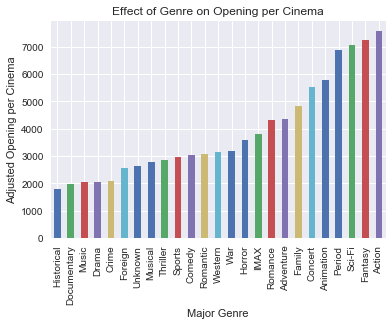

In [733]:
pc.groupby('genre1').mean()['adjusted_opening_per_cinema'].sort_values().plot.bar()
plt.title("Effect of Genre on Opening per Cinema")
plt.xlabel('Major Genre')
plt.ylabel('Adjusted Opening per Cinema')

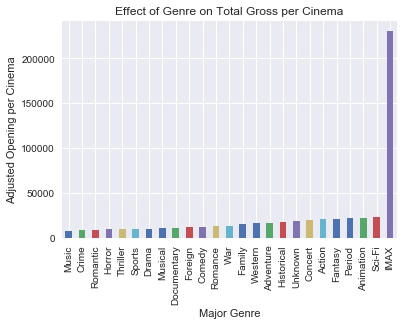

In [735]:
pc.groupby('genre1').mean()['adjusted_total_gross_per_cinema'].sort_values().plot.bar()
plt.title("Effect of Genre on Total Gross per Cinema")
plt.xlabel('Major Genre')
plt.ylabel('Adjusted Opening per Cinema')

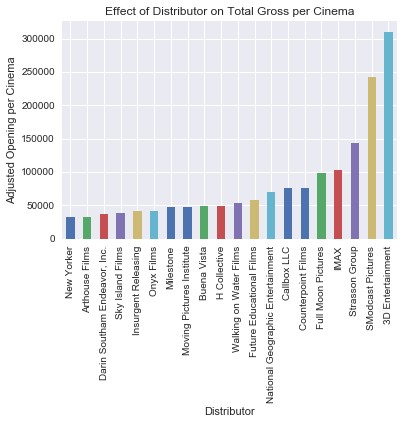

In [736]:
pc.groupby('distributor').mean()['adjusted_total_gross_per_cinema'].sort_values().dropna().tail(20).plot.bar()
plt.title("Effect of Distributor on Total Gross per Cinema")
plt.xlabel('Distributor')
plt.ylabel('Adjusted Opening per Cinema')

In [ ]:
plt.scatter(pc['runtime'], pc)